In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing

In [25]:
X_imputed = pd.read_csv('imputed features_final.csv')
Optimal_Gas = pd.read_csv('Optimal_target_with_92_Q3_2점.csv')

In [26]:
sub_list = list(Optimal_Gas['SubjectID'])

In [27]:
X_imputed = X_imputed[['SubjectID','Age', 'Gender', 'onset_site', 'onset_delta',
       'diag_minus_onset', 'slope_alsfrs_tot',
       'fvc_slope', 'fvc_mean',  'mean_Q10_Respiratory',
       'mean_Bulbar', 'mean_motor', 'slope_Q1_Speech', 'slope_Q2_Salivation',
       'slope_Q3_Swallowing', 'slope_Q4_Handwriting', 'slope_Q5_Cutting',
       'slope_Q6_Dressing_and_Hygiene', 'slope_Q7_Turning_in_Bed',
       'slope_Q8_Walking', 'slope_Q9_Climbing_Stairs', 'slope_Q10_Respiratory']]

In [28]:
X_imputed.query("SubjectID == {0}".format(sub_list), inplace=True)
sub_list_2 = list(X_imputed['SubjectID'])
X_imputed = X_imputed.reset_index()
X_imputed.drop(columns=['index'], inplace=True)

In [29]:
Optimal_Gas.query("SubjectID == {0}".format(sub_list_2), inplace=True)
Optimal_Gas = Optimal_Gas.reset_index()
Optimal_Gas = Optimal_Gas.drop(columns=['index','Unnamed: 0'])
Optimal_Gas

,SubjectID,time_opt,status_opt
0,329,274,0
1,348,401,0
2,708,35,1
3,902,154,0
4,1736,187,1
...,...,...,...
3394,998756,64,0
3395,999166,390,0
3396,999823,91,1
3397,999880,266,0


In [30]:
X_1 = X_imputed.merge(Optimal_Gas, on='SubjectID', how='inner')

In [31]:
X_1 = X_1[X_1['time_opt']!=0]
y = X_1[['status_opt']]
X_2 = X_1.drop(columns='SubjectID')

# Train/Test split

In [32]:
from sklearn.model_selection import train_test_split

df_train, df_test, y_train, y_test = train_test_split(X_2, y, train_size=0.8, test_size=0.2, random_state=11)

# Creating Virtual Subject with mean values of each feature

In [37]:
VIRT = pd.DataFrame(X_1.mean()).transpose().iloc[:, 1:-2]
VIRT

,Age,Gender,onset_site,onset_delta,diag_minus_onset,slope_alsfrs_tot,fvc_slope,fvc_mean,mean_Q10_Respiratory,mean_Bulbar,...,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory
0,55.087673,0.650191,0.139655,-613.068255,339.66343,-0.025917,-0.087364,83.900659,3.610479,6.985822,...,-0.001632,-0.001268,-0.001903,-0.002657,-0.003404,-0.00378,0.01206,-0.002207,-0.004372,-0.001687


# Fitting model

Cox Proportion Hazard model

In [38]:
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.01)
cph.fit(df_train, 'time_opt', event_col='status_opt')

<lifelines.CoxPHFitter: fitted with 2719 total observations, 1787 right-censored observations>

In [39]:
result_cph = cph.predict_survival_function(VIRT)

Random Survival Forest

In [40]:
from sksurv.ensemble import RandomSurvivalForest

In [41]:
dic = {1:True, 0:False}

df_train_rsf = df_train.iloc[:, -2:][['status_opt', 'time_opt']]
df_train_rsf = df_train_rsf.replace({'status_opt':dic})

In [42]:
arr_1 = list(tuple(x) for x in df_train_rsf.to_records(index=False))
dt=np.dtype('bool, float')
y_train_rsf = np.array(arr_1, dtype=dt)
y_train_rsf.dtype.names=['cens', 'time']

In [43]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=20)
rsf.fit(df_train.iloc[:,:-2], y_train_rsf)

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_estimators=1000, n_jobs=-1,
                     random_state=20)

In [44]:
result_rsf = rsf.predict_survival_function(VIRT, return_array=True)

In [71]:
from lifelines import WeibullAFTFitter

In [73]:
aft = WeibullAFTFitter()
aft.fit(df_train, 'time_opt', 'status_opt', ancillary=False)
result_wft = aft.predict_survival_function(VIRT)

In [74]:
from lifelines.utils import median_survival_times

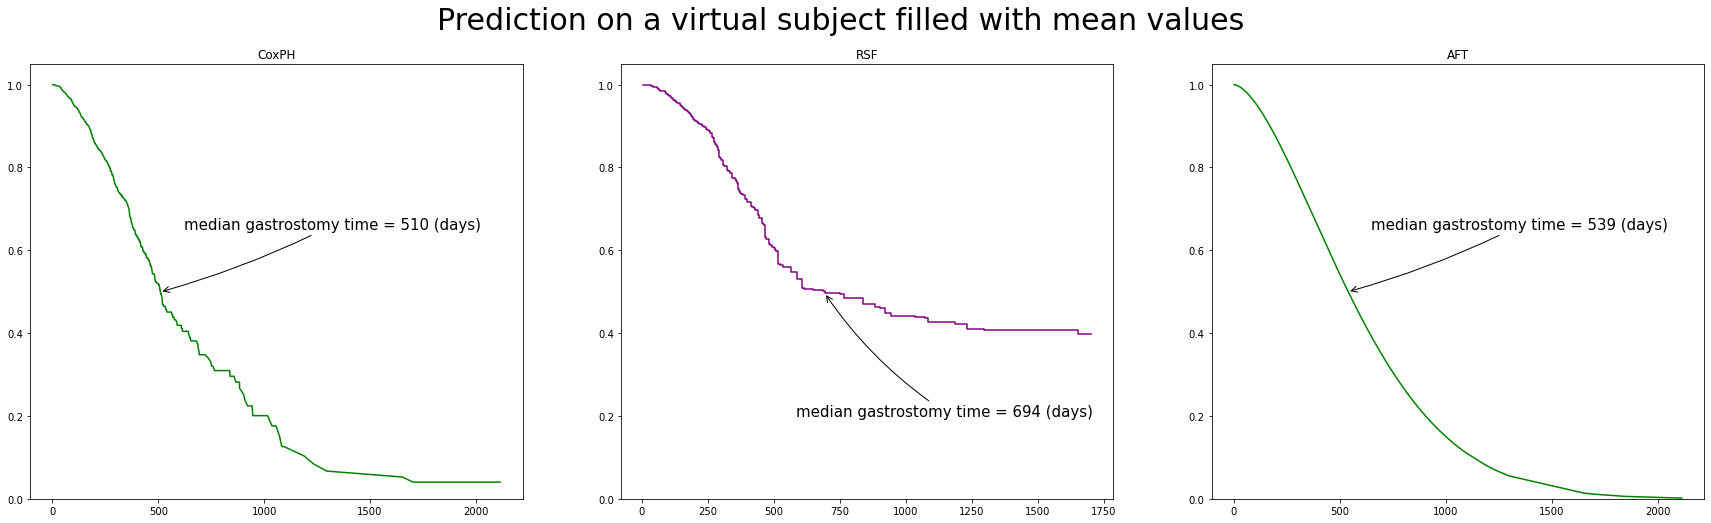

In [81]:
plt.figure(figsize=(30,8))

plt.subplot(131)
plt.plot(result_cph.index, result_cph, marker='None', color='green')
plt.title("CoxPH")
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = 510 (days)", xy=(510, 0.499595)
                , xytext=(510+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"), fontsize=15)

plt.subplot(132)
for i, s in enumerate(result_rsf):
    plt.step(rsf.event_times_, s, where="post", color='purple')
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = 694 (days)", xy=(694, 0.49600802)
                , xytext=(694-110, 0.2), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.1"), fontsize=15)
plt.title('RSF')

plt.subplot(133)
plt.plot(result_wft.index, result_wft[0], marker='None', color='green')
plt.title("Weibull AFT")
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = 539 (days)", xy=(539, 0.500121)
                , xytext=(539+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"), fontsize=15)
plt.title('AFT')

plt.suptitle('Prediction on a virtual subject filled with mean values', fontsize=30)
plt.show()

In [47]:
result_cph[result_cph[0]<=0.51].head()

,0
507.0,0.508137
508.0,0.503924
509.0,0.503924
510.0,0.499595
511.0,0.495268


In [59]:
rsf.event_times_

array([   7.,    8.,   11.,   12.,   13.,   14.,   17.,   21.,   22.,
         27.,   28.,   32.,   33.,   34.,   35.,   36.,   37.,   38.,
         39.,   40.,   41.,   42.,   43.,   44.,   45.,   47.,   48.,
         49.,   50.,   51.,   52.,   53.,   55.,   56.,   57.,   58.,
         59.,   61.,   62.,   63.,   64.,   65.,   66.,   67.,   68.,
         69.,   70.,   71.,   72.,   73.,   74.,   75.,   76.,   77.,
         78.,   80.,   81.,   82.,   83.,   84.,   85.,   86.,   89.,
         91.,   92.,   93.,   94.,   95.,   96.,   97.,   98.,   99.,
        100.,  101.,  102.,  103.,  104.,  105.,  107.,  109.,  110.,
        112.,  113.,  115.,  116.,  117.,  119.,  120.,  121.,  122.,
        123.,  124.,  125.,  126.,  127.,  128.,  129.,  130.,  131.,
        132.,  133.,  134.,  135.,  136.,  137.,  138.,  139.,  140.,
        141.,  142.,  143.,  144.,  147.,  148.,  149.,  150.,  151.,
        152.,  153.,  154.,  155.,  156.,  158.,  160.,  161.,  162.,
        163.,  165.,

In [68]:
result_rsf

array([[0.99994737, 0.99994737, 0.99994737, 0.99994737, 0.99994737,
        0.99977045, 0.99951434, 0.99951434, 0.9984239 , 0.9984239 ,
        0.99826535, 0.99826535, 0.99826535, 0.99826535, 0.99760371,
        0.99753705, 0.99753705, 0.99708067, 0.99707286, 0.99671388,
        0.99585303, 0.9954855 , 0.99537815, 0.99537815, 0.99532552,
        0.99532552, 0.99423021, 0.9941445 , 0.99400077, 0.99396231,
        0.99396231, 0.99384718, 0.99384718, 0.99340727, 0.99311311,
        0.99298247, 0.99296997, 0.99164819, 0.99149068, 0.98909018,
        0.98834929, 0.98817683, 0.98817683, 0.98792862, 0.98792862,
        0.98789015, 0.98564035, 0.98519151, 0.98494245, 0.98488631,
        0.98469479, 0.9843853 , 0.98433768, 0.98427101, 0.98421433,
        0.98392752, 0.98392752, 0.98386791, 0.98351607, 0.98342758,
        0.98342758, 0.98342758, 0.98319839, 0.97986651, 0.9794301 ,
        0.97873346, 0.97807598, 0.97799438, 0.97799438, 0.97760743,
        0.97648782, 0.97586717, 0.9749496 , 0.97